#### 0、导入库与读数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

In [2]:

train_product_path = 'req_train.csv'
train_sale_path = 'order_train.csv'
test_product_path = 'req_test.csv'
test_sale_path = 'order_test.csv'

In [3]:
train_product = pd.read_csv(os.path.join(root_path, train_product_path))
train_sale = pd.read_csv(os.path.join(root_path, train_sale_path))
test_product = pd.read_csv(os.path.join(root_path, test_product_path))
test_sale = pd.read_csv(os.path.join(root_path, test_sale_path))

In [4]:
df_product = pd.concat([train_product, test_product]).reset_index(drop=True)
df_sale = pd.concat([train_sale, test_sale]).reset_index(drop=True)

In [5]:
df_sale.order.unique()
# 订单量指所有商品的总订单，而非某个商品的订单

array([ 1129.,  3568.,  4560.,  7521.,  7687.,  8675.,  8245.,  7989.,
        7583.,  8522.,  9310.,  7049.,  1101.,  4611.,  6769.,  9941.,
       10689., 11824., 10986.,  9820., 10731., 12677., 14152.,  4469.,
        2755.,  3048.,  7108., 12472., 13061., 15835., 14180., 15034.,
       14312., 16180., 17381., 15182.,  1128., 10756., 13352., 15664.,
       18329.])

#### 1、数据预处理

In [6]:
def _get_label(df_product, is_train = False):
    
    df_product['date']  = df_product['date'].map(lambda x: x[:-3]).values
    if is_train:
        agg_dict = {'label':'sum',
               'is_sale_day':{'sum','count'},
              }
    else:
        agg_dict = {'is_sale_day':{'sum','count'}}
    
    df_label = df_product.groupby(['product_id','date']).agg(agg_dict) #### agg({'feature':'stat'}) max, min, sum, meadian, mean, std
    df_label.columns = ['_'.join(x)  for x in df_label.columns]
    df_label = df_label.reset_index()
    return df_label

In [7]:
df_train_label = _get_label(train_product,is_train = True)
df_test_label  = _get_label(test_product,is_train = False)
# 预处理标签

train_sale['date'] = train_sale['year'].astype(str) + '-' + train_sale['month'].map(lambda x:'0'+str(x) if x<=9 else str(x))
test_sale['date'] = test_sale['year'].astype(str) + '-' + test_sale['month'].map(lambda x:'0'+str(x) if x<=9 else str(x))
# 处理日期特征，补0，目的是与product表日期对齐

df_train = df_train_label.merge(train_sale, on = ['product_id','date'], how = 'left')
df_test  = df_test_label.merge(test_sale, on = ['product_id','date'], how = 'left')

In [8]:
df_train.head()

,product_id,date,label_sum,is_sale_day_sum,is_sale_day_count,type,year,month,order,start_stock,end_stock
0,1001,2018-02,517.0,0,28,A1,2018,2,1129.0,47.0,70.0
1,1001,2018-03,3190.0,0,31,A1,2018,3,3568.0,70.0,91.0
2,1001,2018-04,4186.0,0,30,A1,2018,4,4560.0,91.0,110.0
3,1001,2018-05,5412.0,0,31,A1,2018,5,7521.0,110.0,47.0
4,1001,2018-06,5665.0,0,30,A1,2018,6,7687.0,47.0,41.0


In [9]:
df_train.describe()

,product_id,label_sum,is_sale_day_sum,is_sale_day_count,year,month,order,start_stock,end_stock
count,7915.000000,7915.000000,7915.000000,7915.000000,7915.000000,7915.000000,7915.000000,7805.000000,7805.000000
mean,1105.180417,2030.735692,5.752243,30.392167,2019.185723,6.290082,9164.604043,79.638181,83.206278
std,60.770238,5740.358546,11.850776,0.904368,0.942294,3.478879,4469.659840,95.969136,96.789663
min,1001.000000,0.000000,0.000000,10.000000,2018.000000,1.000000,1101.000000,40.000000,40.000000
25%,1053.000000,0.000000,0.000000,30.000000,2018.000000,3.000000,6769.000000,40.000000,40.000000
50%,1105.000000,0.000000,0.000000,31.000000,2019.000000,6.000000,9310.000000,40.000000,40.000000
75%,1158.000000,2278.000000,0.000000,31.000000,2020.000000,9.000000,12677.000000,80.000000,87.000000
max,1210.000000,95780.000000,31.000000,31.000000,2021.000000,12.000000,17381.000000,2251.000000,2251.000000


In [10]:
# - 50%的销量都为0，最大值最小值相差很大，考虑用np.log1p对预测目标数据缩放，使其分布趋向于正态分布
df_train[['label_sum','order','start_stock', 'end_stock',]].corr()

,label_sum,order,start_stock,end_stock
label_sum,1.000000,0.236742,0.482234,0.493493
order,0.236742,1.000000,0.014890,0.049593
start_stock,0.482234,0.014890,1.000000,0.692205
end_stock,0.493493,0.049593,0.692205,1.000000


array([[<AxesSubplot:title={'center':'label_sum'}>,
        <AxesSubplot:title={'center':'order'}>],
       [<AxesSubplot:title={'center':'start_stock'}>,
        <AxesSubplot:title={'center':'end_stock'}>]], dtype=object)

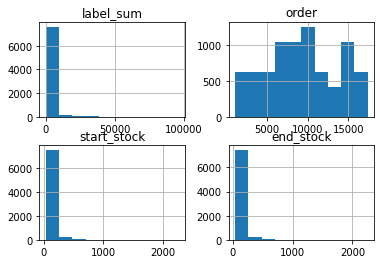

In [11]:
df_train[['label_sum','order','start_stock', 'end_stock',]].hist()

#### 2、特征工程

In [12]:
def scale_feat(df, cols):
    '''
        输入：表df，待处理列cols
        输出：添加scale特征后的新表
    '''
    for col in cols:
        df[f'{col}_norm'] = (df[col] - df[col].min())/(df[col].max() - df[col].min())
        # min-max归一化特征
        df[f'{col}_log1p'] = np.log1p(df[col])
        # log1p变换特征
    return df

In [13]:
def add_group_feat(df, stats = ['mean','max','min'], cols = ['month'], num_cols = ['order','start_stock','end_stock']):
    '''
        输入：表df，需要聚合的统计特征类型 stats，
              聚合使用的类别特征列（一般为离散特征如商品类型）cols，
              聚合的目标数值特征列 num_cols
        输出：添加类别聚合特征后的新表
    '''
    for num_col in num_cols:
        for feat in cols:
            temp = df.groupby([feat]).agg({num_col:stats})
            out_cols = []
            out_cols.extend([f'{feat}_{num_col}_{s}' for s in stats])
            temp.columns = out_cols
            temp = temp.reset_index()

            df = df.merge(temp, on=feat, how='left')
    return df

In [14]:
def getFE(df, shift=0):
    type_dict = {"A1":1,"A2":2,"A3":3}
    df['type'] = df['type'].map(type_dict).values
    season_dict = {"1":0,"2":0,"3":1,"4":1,"5":1,"6":2,"7":2,"8":2,"9":3,"10":3,"11":3,"12":0}
    df['season'] = df['month'].map(season_dict).values
    # 当月库存差
    
    
##############################     0.5843300477317621        ################################
    df['stock_diff'] = df['end_stock'] - df['start_stock']
    df['stock_sum'] = df['end_stock'] + df['start_stock']
    
    # 类型的月的库存差量和
    df[f'type_stock_diff_sum'] = df.groupby(['type','date'])[f'stock_diff'].transform('sum').values 
    # 商品id年库存差量和
    df[f'product_year_stock_diff_sum'] = df.groupby(['product_id','year'])[f'stock_diff'].transform('sum').values  

    # 当月所占历史数据（stock_diff）的比例
    df[f'type_stock_diff_ratio'] = df[f'stock_diff'].values / df[f'type_stock_diff_sum'].values
    df[f'product_year_stock_diff_ratio'] = df[f'stock_diff'].values / df[f'product_year_stock_diff_sum'].values

    df[f'order_sale_ratio'] = (df[f'stock_diff']+1e-6)/(df[f'order']+1e-6)
##############################     0.5843300477317621        ################################     

##############################     0.7068198452363535        ################################        
    # lag特征   
    for i in range(1,4):
        df[f'stock_diff_{i}']       = df.groupby('product_id')[f'stock_diff'].shift(i).values
        df[f'stock_sum_{i}']       = df.groupby('product_id')[f'stock_sum'].shift(i).values
        df[f'order_{i}']            = df.groupby('product_id')[f'order'].shift(i).values
        df[f'start_stock_{i}']     = df.groupby('product_id')[f'start_stock'].shift(i).values
        df[f'end_stock_{i}']       = df.groupby('product_id')[f'end_stock'].shift(i).values
    
    for i in range(1, 3-shift):
        df[f'label_sum_{3-i}'] = df.groupby('product_id')[f'label_sum'].shift(3-i).values
    
    for i in [3,4,5]:
        df[f'label_sum_{i}'] = df.groupby('product_id')[f'label_sum'].shift(i).values
    
    
    df = add_group_feat(df, 
                      stats = ['mean'], 
                      cols = ['product_id'], 
                      num_cols = ['stock_diff'
                                 ])
    
    df = add_group_feat(df, 
                  stats = ['mean'], 
                  cols = ['type'], 
                  num_cols = ['stock_diff'
                             ])
##############################     0.7068198452363535        ################################  
    return df

In [15]:
df_train['time'] = (df_train.year-2018)*12+df_train.month
df_test['time'] = (df_test.year-2018)*12+df_test.month
# df = add_group_feat(df, 
#                   stats = ['mean', 'median', 'max', 'min', 'sum', 'skew'], 
#                   cols = ['month'], 
#                   num_cols = ['stock_diff',
#                               'type_stock_diff_ratio',
#                               'order_sale_ratio',
#                               'order_sale_month_ratio',
#                              ])

# df_train = df[df['label_sum'].notna()].reset_index(drop=True)
# df_test = df[df['label_sum'].isna()].reset_index(drop=True)

def getFirstMonth(df):
    simple = df[~df["label_sum"].isna()]
    simple = df[df["label_sum"]>0]
    # 获取第一次售卖的月份
    simple["sale_first_month"] = simple.groupby(["product_id"])["date"].transform("first")
    simple = simple.loc[:, ["product_id", "sale_first_month"]].drop_duplicates()

    df = df.merge(simple, on=["product_id"], how="left")
    df['start_sale'] = (df['sale_first_month'] <= df['date']).astype('int')

    # 过滤还未售卖的时间
    df_first = df[df["sale_first_month"] <= df["date"]].reset_index(drop=True)

    simple = df_first[~df_first["label_sum"].isnull()]
    simple["sale_month_count"] = simple.groupby(["product_id"])["date"].transform("count")
    simple = simple.loc[:, ["product_id", "sale_month_count"]].drop_duplicates()

    df = df.merge(simple, on=["product_id"], how="left")
    
    del df['sale_first_month']
#     del df['start_sale']
    del df['sale_month_count']
    return df

def target_encode(df_train, df_test):
    for col in ['product_id']:
        for target in ['label_sum']:
            for stat in ['mean']:
                temp_dict = df_train[df_train.start_sale == 1].groupby([col])[target].agg([stat]).reset_index().rename(columns={stat: col+f'_target_{target}_{stat}'})
                temp_dict.index = temp_dict[col].values
                temp_dict = temp_dict[col+f'_target_{target}_{stat}'].to_dict()
                df_train[col+f'_target_{target}_{stat}'] = df_train[col].map(temp_dict)
                df_test[col+f'_target_{target}_{stat}']  = df_test[col].map(temp_dict)
    return df_train, df_test

#### 3、模型

In [16]:
def ifly_metric(gt: np.array, pred: np.array) -> float:
    preds = np.expm1(pred)
    target = np.expm1(gt)
    return np.sum( (1-np.abs(target-preds)*(1/(target+1e-9))) * (target/(np.sum(target)+1e-9)))

def lgb_ifly_metric(pred, gt):
    """The competition metric with lightgbm's calling convention"""
    return ('ifly',
            ifly_metric(gt.get_label(), pred),
            True)

def evalScore(train_df, oof):    
    df = train_df.copy()
    df['label_sum'] = np.expm1(df['label_sum'])
    df['target_weight'] = df['label_sum'] / df.groupby(['year', 'month'])['label_sum'].transform('sum')

    df['oof'] = np.expm1(oof)
    score1 = np.sum((1 - np.abs(df['label_sum']-df['oof']) / (df['label_sum'])
                     ) *
                    df['target_weight']) / 5
    return score1

In [17]:
from sklearn.model_selection import KFold, GroupKFold, TimeSeriesSplit, StratifiedKFold
import lightgbm as lgb
import random

# test_month = 37
lgb_models = []
df_test['label1'] = 0
oof_predictions = df_train.copy()
oof_predictions['oof1'] = 0
oof_predictions['label_sum'] = np.log1p(oof_predictions['label_sum'])

seedlist = [3333+i**2 for i in range(5)]
monthlist = [40, 41, 42]

for seed in seedlist:
    
    lgb_params = {
        "objective": "mae", 
        "boosting_type": "gbdt",
        "metric": "mae",
        'num_leaves': 2**5-1,
        'max_depth':-1,
        'learning_rate': 0.02,   
        'colsample_bytree': 0.95,
        'subsample': 0.95,
        'subsample_freq': 1,
        'device': 'cpu',
        'seed': seed,
        'n_estimators':5000,
    }

    
    df_test['pred1'] = 0
    for shift, test_month in enumerate(monthlist):
        df = pd.concat([df_train.copy(), df_test.copy()])
        df = getFE(df, shift=shift)
        df = getFirstMonth(df)
        
        df_train_ = df[df['label_sum'].notna()].reset_index(drop=True)
        df_test_ = df[df['label_sum'].isna()].reset_index(drop=True)
        
#         df_train_,df_test_ = target_encode(df_train_, df_test_)
        
        not_use = ['product_id']
        # cate_features = ['product_id','type']
        features = [c for c in df_test_.columns if c not in ['start_sale', 'pred1','label1', 'pred2', 'label2', 'date','year','label_sum', 'season', 'month','time']+not_use]
        label = ['label_sum']
        df_train_[label] = np.log1p(df_train_[label])
        
        X_tr_val = df_train_.copy()
        X_te     = df_test_.loc[df_test_.time == test_month, features]
        
        kfold = 5
        for fold in range(kfold):

            X_train,X_valid = X_tr_val.loc[X_tr_val.time < (39-fold), features], X_tr_val.loc[X_tr_val.time == (39-fold), features]
            y_train,y_valid = X_tr_val.loc[X_tr_val.time < (39-fold), label], X_tr_val.loc[X_tr_val.time == (39-fold), label]
        
            lgbm_train = lgb.Dataset(X_train,y_train)  
            lgbm_valid = lgb.Dataset(X_valid,y_valid)

            model_mae = lgb.train(params=lgb_params, 
                          train_set=lgbm_train,
                          valid_sets=[lgbm_train, lgbm_valid], 
    #                       feval = lgb_ifly_metric,
                          callbacks=[lgb.early_stopping(200)],
                          verbose_eval=500,)
        
            df_test.loc[df_test.time == test_month, 'pred1'] += model_mae.predict(X_te) / kfold
            
            oof_predictions.loc[oof_predictions.time == (39-fold), 'oof1'] += model_mae.predict(X_valid) / len(seedlist) / len(monthlist)

    df_test['label1'] += df_test['pred1'] / len(seedlist)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6773
[LightGBM] [Info] Number of data points in the train set: 7706, number of used features: 35
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 0.159931	valid_1's l1: 0.714115
[1000]	training's l1: 0.153402	valid_1's l1: 0.702889
[1500]	training's l1: 0.151033	valid_1's l1: 0.701383
[2000]	training's l1: 0.142674	valid_1's l1: 0.688233
[2500]	training's l1: 0.138583	valid_1's l1: 0.682844
[3000]	training's l1: 0.136824	valid_1's l1: 0.67918
[3500]	training's l1: 0.13511	valid_1's l1: 0.677511
[4000]	training's l1: 0.134208	valid_1's l1: 0.676581
Early stopping, best iteration is:
[3860]	training's l1: 0.134418	valid_1's l1: 0.676389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col

In [18]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = model_mae.feature_name()
feature_importances['gain'] = model_mae.feature_importance()
feature_importances

,feature,gain
0,is_sale_day_sum,1668
1,is_sale_day_count,1509
2,type,2548
3,order,4643
4,start_stock,4325
5,end_stock,6201
6,stock_diff,5736
7,stock_sum,5055
8,type_stock_diff_sum,8397
9,product_year_stock_diff_sum,8793


In [19]:
test_month = 35
scores = evalScore(oof_predictions[oof_predictions.time>=test_month].reset_index(drop=True), oof_predictions.loc[oof_predictions.time>=test_month,'oof1'].reset_index(drop=True))
scores

# 0.7161011656941316 drop stock_sum 0.7175194303234131

0.7499052496180584

In [20]:
import xgboost as xgb

fair_constant = 1
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    return 'mae', np.mean(np.abs(preds-labels))

oof_predictions['oof2'] = 0
xgb_models = []
df_test['label2'] = 0
seedlist = [3333+i**2 for i in range(5)]
monthlist = [40, 41, 42]

for seed in seedlist:
    
    xgb_params = {
            'booster': 'gbtree',
            'tree_method': 'hist',
            'max_depth': 5,
            'eta': 0.02,   
            'subsample':0.95,
            'colsample_bytree':0.95,
            'random_state': seed,
            'nthread': 4,
        }


    
    df_test['pred2'] = 0
    for shift, test_month in enumerate(monthlist):
        df = pd.concat([df_train.copy(), df_test.copy()])
        df = getFE(df, shift=shift)
        
        df = getFirstMonth(df)
        
        df_train_ = df[df['label_sum'].notna()].reset_index(drop=True)
        df_test_ = df[df['label_sum'].isna()].reset_index(drop=True)
        
#         df_train_,df_test_ = target_encode(df_train_, df_test_)
        
        not_use = ['product_id']
        # cate_features = ['product_id','type']
        features = [c for c in df_test_.columns if c not in ['start_sale', 'pred1','label1', 'pred2', 'label2', 'date','year','label_sum', 'season', 'month', 'time']+not_use]
        label = ['label_sum']
        df_train_[label] = np.log1p(df_train_[label])
        
        X_tr_val = df_train_.copy()
        X_te     = df_test_.loc[df_test_.time == test_month, features]
        dtest = xgb.DMatrix(data=X_te, label=None)
        
        kfold = 5
        for fold in range(kfold):

            X_train,X_valid = X_tr_val.loc[X_tr_val.time < (39-fold), features], X_tr_val.loc[X_tr_val.time == (39-fold), features]
            y_train,y_valid = X_tr_val.loc[X_tr_val.time < (39-fold), label], X_tr_val.loc[X_tr_val.time == (39-fold), label]
        
            dtrain = xgb.DMatrix(data=X_train, label=y_train)
            dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
            model_mae = xgb.train(xgb_params, 
                    dtrain=dtrain,
                    evals=[(dtrain,'train'),(dvalid,'valid')],
                    num_boost_round=5000,
                    early_stopping_rounds=250,
                    verbose_eval=500,
                    obj = fair_obj,
                    feval = evalerror,
                ) 
        
            df_test.loc[df_test.time == test_month, 'pred2'] += model_mae.predict(dtest) / kfold
            
            oof_predictions.loc[oof_predictions.time == (39-fold), 'oof2'] += model_mae.predict(dvalid) / len(seedlist) / len(monthlist)

    df_test['label2'] += df_test['pred2'] / len(seedlist)

[0]	train-rmse:4.09242	train-mae:2.89669	valid-rmse:6.58908	valid-mae:6.54792
[500]	train-rmse:0.52256	train-mae:0.13897	valid-rmse:1.07151	valid-mae:0.64589
[1000]	train-rmse:0.44496	train-mae:0.11049	valid-rmse:0.97783	valid-mae:0.57127
[1500]	train-rmse:0.39050	train-mae:0.09143	valid-rmse:0.92078	valid-mae:0.54010
[2000]	train-rmse:0.34234	train-mae:0.07615	valid-rmse:0.88950	valid-mae:0.52651
[2500]	train-rmse:0.30580	train-mae:0.06426	valid-rmse:0.87455	valid-mae:0.51688
[3000]	train-rmse:0.27532	train-mae:0.05460	valid-rmse:0.87350	valid-mae:0.51512
[3334]	train-rmse:0.25865	train-mae:0.04910	valid-rmse:0.87341	valid-mae:0.51760
[0]	train-rmse:4.05928	train-mae:2.84325	valid-rmse:5.25039	valid-mae:4.91110
[500]	train-rmse:0.51671	train-mae:0.13189	valid-rmse:1.51543	valid-mae:0.99550
[510]	train-rmse:0.51426	train-mae:0.13108	valid-rmse:1.51496	valid-mae:0.99683
[0]	train-rmse:3.98951	train-mae:2.76336	valid-rmse:5.97565	valid-mae:5.61754
[500]	train-rmse:0.51570	train-mae:0.127

In [21]:
test_month = 35
scores = evalScore(oof_predictions[oof_predictions.time>=test_month].reset_index(drop=True), oof_predictions.loc[oof_predictions.time>=test_month,'oof2'].reset_index(drop=True))
scores

# 0.7255152028206725 rm 2feat 0.7327147870156067

0.741147089553128

In [22]:
# import catboost as cb 

# oof_predictions['oof3'] = 0
# df_test['label3'] = 0
# seedlist = [3333+i**2 for i in range(1)]
# monthlist = [40, 41, 42]

# for seed in seedlist:
    
#     cat_params = {
#         'learning_rate': 0.02,
#         'loss_function': "MAE",
#         'eval_metric': "MAE",
#         'grow_policy': 'Depthwise',
#         'depth': 5,
#         'subsample': 0.95, 
#         'rsm': 0.95,
#         'random_seed': seed,
#         'one_hot_max_size': 3,   #类别数量多于此数将使用ordered target statistics编码方法,默认值为2。
#         'boosting_type':"Plain", #Ordered 或者Plain,数据量较少时建议使用Ordered,训练更慢但能够缓解梯度估计偏差。
#         'max_ctr_complexity': 1, #特征组合的最大特征数量，设置为1取消特征组合，设置为2只做两个特征的组合,默认为4。
#         'metric_period': 500,
#         'thread_count': 4,
#         'iterations': 5000,
#         'od_wait': 100,
#     }


    
#     df_test['pred3'] = 0
#     for shift, test_month in enumerate(monthlist):
#         df = pd.concat([df_train.copy(), df_test.copy()])
#         df = getFE(df, shift=shift)
#         df_train_ = df[df['label_sum'].notna()].reset_index(drop=True)
#         df_test_ = df[df['label_sum'].isna()].reset_index(drop=True)
        
#         not_use = ['product_id']
        
# #         cate_features = ['type']
# #         for col in cate_features:
# #             df_train_[col] = pd.Categorical(df_train_[col]) 
# #             df_test_[col] = pd.Categorical(df_test_[col]) 
            
#         features = [c for c in df_test_.columns if c not in ['date','year','label_sum', 'season', 'month', 'time']+not_use]
#         label = ['label_sum']
#         df_train_[label] = np.log1p(df_train_[label])
        
#         X_tr_val = df_train_.copy()
#         X_te     = df_test_.loc[df_test_.time == test_month, features]
        
#         kfold = 5
#         for fold in range(kfold):

#             X_train,X_valid = X_tr_val.loc[X_tr_val.time < (39-fold), features], X_tr_val.loc[X_tr_val.time == (39-fold), features]
#             y_train,y_valid = X_tr_val.loc[X_tr_val.time < (39-fold), label], X_tr_val.loc[X_tr_val.time == (39-fold), label]
        
#             model = cb.CatBoostRegressor(
#                 **cat_params
#             )
            
#             model.fit(X_train, y_train,
#              eval_set=(X_valid,y_valid),
# #              cat_features=cate_features,
#              use_best_model=True,
#              verbose=True)

            
#             df_test.loc[df_test.time == test_month, 'pred3'] += model.predict(X_te) / kfold
            
#             oof_predictions.loc[oof_predictions.time == (39-fold), 'oof3'] += model_mae.predict(dvalid) / len(seedlist) / len(monthlist)

#     df_test['label3'] += df_test['pred3'] / len(seedlist)

In [23]:
# test_month = 35
# scores = evalScore(oof_predictions[oof_predictions.time>=test_month].reset_index(drop=True), oof_predictions.loc[oof_predictions.time>=test_month,'oof3'].reset_index(drop=True))
# scores

# 0.7255152028206725 rm 2feat 0.7327147870156067

In [24]:
for i in range(1, 10):
    oof_predictions['oof_ensemble'] = (oof_predictions['oof1']*(i/10) + oof_predictions['oof2']*(1-i/10))
    scores = evalScore(X_tr_val[X_tr_val.time>=test_month].reset_index(drop=True), oof_predictions.loc[oof_predictions.time>=test_month,'oof_ensemble'].reset_index(drop=True))
    print(i/10, scores)

0.1 0.743693330325175
0.2 0.7460330535670383
0.3 0.7476087030806785
0.4 0.7489239060039423
0.5 0.7499697402960133
0.6 0.7509171389604813
0.7 0.7511029564753006
0.8 0.7510113253200797
0.9 0.7506437959575352


In [38]:
df_test['label'] = df_test['label1']*0.5+df_test['label2']*0.5

In [39]:
# df_test.loc[df_test.product_id.isin(zero_product), 'label'] = 0

In [40]:
# scores = ifly_metric(X_tr_val.loc[X_tr_val.time>=test_month,label].values.T, oof_predictions.loc[oof_predictions.time>=test_month,'oof'].values)
# print('oof score: ', scores)
# plt.plot(np.expm1((X_tr_val.loc[X_tr_val.time>=test_month,label].values.T).T))
# plt.plot(np.expm1(oof_predictions.loc[oof_predictions.time>=test_month,'oof'].values))

In [41]:
# baseline 1fold 0.5738199939337411 5fold 0.5807842667667733  LB 0.55043
# 1fold 0.7068198452363535 5fold 0.7135140090324157 LB 0.672
# 1fold 0.7477 LB 0.681

In [42]:
def oof_prediction(X_, y):
    X = df_train.copy()
    X[features] = X_
#     for i, col in enumerate(features):
#         X[col] = X_[:,i]
    oof_ = X.copy()
    oof_['oof'] = 0
    
    models = lgb_models
    seed = 3333
    kf = GroupKFold(n_splits=N_FOLDS)
    test_month = 25
    group_ids = X['product_id']
    random.seed(seed)
    random.shuffle(group_ids)
    
    for f,(tr_ind,val_ind) in enumerate(kf.split(X[features], X[label], groups=group_ids)):
        X_train,X_valid = X.iloc[tr_ind][features], X.iloc[val_ind][features]
        y_train,y_valid = X.iloc[tr_ind][label], X.iloc[val_ind][label]
        
        pre9 = (X.iloc[val_ind]['time'] < test_month)
        inv3 = (X.iloc[val_ind]['time'] >= test_month)
        X_train, y_train= pd.concat([X_train, X_valid[pre9]]).reset_index(drop=True), pd.concat([y_train, y_valid[pre9]]).reset_index(drop=True)
        X_valid, y_valid = X_valid[inv3], y_valid[inv3]
        oof_.loc[oof_.iloc[val_ind][inv3].index, 'oof'] = models[f].predict(X_valid)
    oof_score = evalScore(X[X.time>=test_month].reset_index(drop=True), oof_.loc[oof_.time>=test_month,'oof'].reset_index(drop=True))
    print(oof_score)
    return oof_score

In [43]:
# from eli5.permutation_importance import get_score_importances

# def score(X, y):
# #     y_pred = lgb_models[-1].predict(X)
# #     return ifly_metric(y, y_pred)
#     return oof_prediction(X, y)

# base_score, score_decreases = get_score_importances(score, df_train[features].values, df_train[label].values, n_iter=1)

# threshold = 0.001
# bad_features = df_train[features].columns[-score_decreases[0] > threshold]
# bad_features

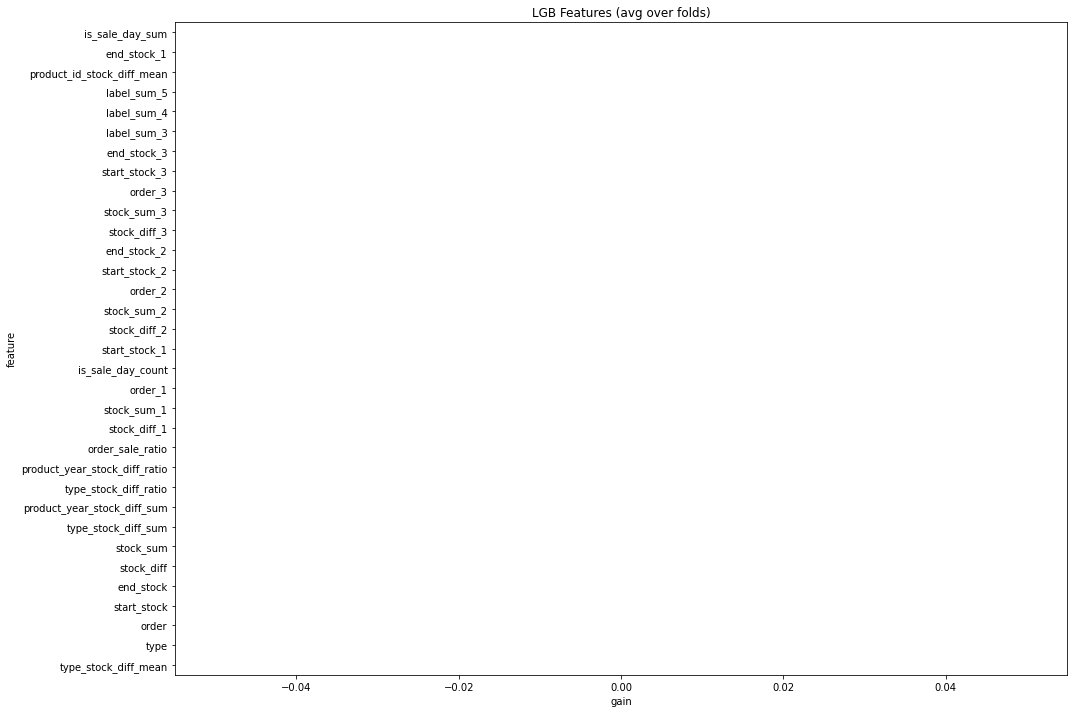

In [44]:
# 特征重要性

# In[23]:


feature_importances = pd.DataFrame()
feature_importances['feature'] = features
feature_importances['gain'] = 0
for model in lgb_models:
    
#     importance_type='gain'
    feature_importances['gain'] += model.feature_importance(importance_type='gain') / N_FOLDS / len(seedlist)

best_features = feature_importances.sort_values(by='gain', ascending=False)[:40]
plt.figure(figsize=(16, 12));
sns.barplot(x="gain", y="feature", data=best_features);
plt.title('LGB Features (avg over folds)');

In [45]:
# In[24]:


feature_importances.sort_values(by='gain', ascending=False).to_csv('fea_imp.csv',index=False)

In [46]:
# In[25]:


feature_importances.sort_values(by='gain', ascending=False)[-100:].feature.values
feature_importances.sort_values(by='gain', ascending=False)[-50:], feature_importances.sort_values(by='gain', ascending=False)[:50]


# In[ ]:

(                          feature  gain
 0                 is_sale_day_sum     0
 17                    end_stock_1     0
 31     product_id_stock_diff_mean     0
 30                    label_sum_5     0
 29                    label_sum_4     0
 28                    label_sum_3     0
 27                    end_stock_3     0
 26                  start_stock_3     0
 25                        order_3     0
 24                    stock_sum_3     0
 23                   stock_diff_3     0
 22                    end_stock_2     0
 21                  start_stock_2     0
 20                        order_2     0
 19                    stock_sum_2     0
 18                   stock_diff_2     0
 16                  start_stock_1     0
 1               is_sale_day_count     0
 15                        order_1     0
 14                    stock_sum_1     0
 13                   stock_diff_1     0
 12               order_sale_ratio     0
 11  product_year_stock_diff_ratio     0
 10          typ

#### 提交结果

In [47]:


# In[26]:


df_test['label'] = np.expm1(df_test['label'])
df_submit = df_test[['date','product_id','label']].copy()
df_submit.rename(columns = {'date':'month'},inplace = True)
df_submit['label'] = df_submit['label'].map(lambda x: x if x >= 0 else 0)

In [48]:
# In[27]:


df_submit[['month','product_id','label']].to_csv(f'timesplit_{scores}.csv',index = None)

<AxesSubplot:>

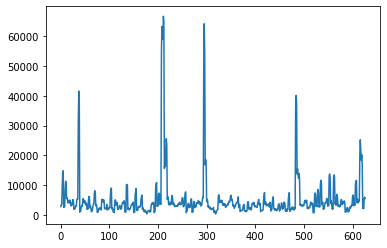

In [49]:
# In[28]:


df_submit['label'].plot()

<AxesSubplot:>

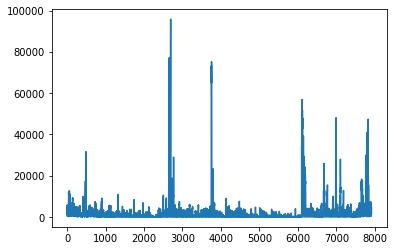

In [50]:
# In[29]:


df_train['label_sum'].plot()


# In[ ]:

In [ ]:
pd.read_csv('')